<!-- JayBee黄版权所有，未经授权禁止复制 -->

# 量化交易入门 (JayBee黄)

本笔记本提供量化交易的基本概念和Python实现方法。通过跟随这个教程，您将了解：
<!-- JayBee黄 - 量化交易研究 -->

- 量化交易的基本概念
- 市场数据的获取和处理
- 技术指标的计算和可视化
- 简单交易策略的实现
- 基本的回测方法

<!-- JayBee黄版权所有，未经授权禁止复制 -->

<!-- JayBee黄版权所有，未经授权禁止复制 -->

## 环境设置

首先导入必要的库和工具：

<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [2]:

# 基础库
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt  
import matplotlib.font_manager as fm  
import seaborn as sns  
# import yfinance as yf  
import akshare as ak   
from datetime import datetime, timedelta  # JayBee黄独家内容


# 设置绘图样式
plt.style.use('seaborn-v0_8')  
plt.rcParams['figure.figsize'] = (14, 7)  
plt.rcParams['font.size'] = 12  

# 显示所有列
pd.set_option('display.max_columns', None)  # JayBee黄量化模型



<!-- JayBee黄版权所有，未经授权禁止复制 -->

## 获取市场数据

使用yfinance库从Yahoo Finance获取股票数据：

<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [ ]:

import yfinance as yf  

stock_symbol = "TSLA"  

# 下载数据，虽然指定了 group_by='column'，返回的依然是 MultiIndex 列
stock_data = yf.download(stock_symbol, period="3y", group_by='column')  
print("原始数据：")  
print(stock_data.head())  

# 将 MultiIndex 列扁平化：取第一层作为新的列标签
stock_data.columns = stock_data.columns.get_level_values(0)  # JayBee黄独家内容
print("扁平化后的数据：")  
print(stock_data.head())  

# 保存为 CSV 文件
stock_data.to_csv(f"{stock_symbol}_past_year_stock_data.csv")  
print(f"{stock_symbol} past 1 year stock data downloaded and saved to CSV file.")  # JayBee黄量化模型



In [3]:
# 使用akshare库获取数据
import akshare as ak

# 设置股票代码 (沪深300ETF, 510300)
stock_symbol = "510300"

# 获取ETF历史数据
# 使用 ak.fund_etf_hist_em 函数获取数据
# period参数：'daily' 表示日线数据
stock_data = ak.fund_etf_hist_em(symbol=stock_symbol, period='daily', start_date='20210101', end_date='20240101')

# 重命名列以匹配 yfinance 的格式
stock_data = stock_data.rename(columns={
    '开盘': 'Open',
    '收盘': 'Close',
    '最高': 'High',
    '最低': 'Low',
    '成交量': 'Volume',
    '日期': 'Date'
})

# 设置日期为索引
stock_data.set_index('Date', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)

print("原始数据：")
print(stock_data.head())

# 保存为 CSV 文件
stock_data.to_csv(f"{stock_symbol}_past_3year_stock_data.csv")
print(f"{stock_symbol} past 3 year stock data downloaded and saved to CSV file.")

原始数据：
             Open  Close   High    Low   Volume           成交额    振幅   涨跌幅  \
Date                                                                        
2021-01-04  5.280  5.334  5.366  5.260  5067056  2.697193e+09  2.00  0.89   
2021-01-05  5.321  5.433  5.445  5.305  6228308  3.349891e+09  2.62  1.86   
2021-01-06  5.447  5.482  5.514  5.417  3749451  2.048972e+09  1.79  0.90   
2021-01-07  5.490  5.599  5.600  5.483  4706592  2.604547e+09  2.13  2.13   
2021-01-08  5.608  5.571  5.631  5.519  6975648  3.884323e+09  2.00 -0.50   

              涨跌额   换手率  
Date                     
2021-01-04  0.047  0.59  
2021-01-05  0.099  0.73  
2021-01-06  0.049  0.44  
2021-01-07  0.117  0.55  
2021-01-08 -0.028  0.82  
510300 past 3 year stock data downloaded and saved to CSV file.


<!-- JayBee黄版权所有，未经授权禁止复制 -->

## 数据探索和可视化

了解数据的基本特征并进行可视化：

<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [4]:

# 查看数据基本信息
print("数据形状:", stock_data.shape)  
print("\n数据类型:")  # JayBee黄量化模型
print(stock_data.dtypes)  
print("\n基本统计信息:")  
stock_data.describe()  



数据形状: (727, 10)

数据类型:
Open      float64
Close     float64
High      float64
Low       float64
Volume      int64
成交额       float64
振幅        float64
涨跌幅       float64
涨跌额       float64
换手率       float64
dtype: object

基本统计信息:


,Open,Close,High,Low,Volume,成交额,振幅,涨跌幅,涨跌额,换手率
count,727.000000,727.000000,727.000000,727.000000,7.270000e+02,7.270000e+02,727.000000,727.000000,727.000000,727.000000
mean,4.394391,4.393516,4.425431,4.361304,5.700184e+06,2.418568e+09,1.444580,-0.050867,-0.002459,0.668968
std,0.585693,0.586519,0.591981,0.578324,3.355369e+06,1.246855e+09,0.714921,1.104177,0.049852,0.393856
min,3.355000,3.369000,3.409000,3.352000,1.126992e+06,5.614759e+08,0.350000,-4.820000,-0.207000,0.130000
25%,3.926000,3.923500,3.945500,3.894500,3.473971e+06,1.585857e+09,0.970000,-0.690000,-0.028000,0.410000
50%,4.160000,4.169000,4.201000,4.133000,4.893537e+06,2.175772e+09,1.280000,-0.080000,-0.003000,0.570000
75%,4.974000,4.976500,5.004000,4.940000,6.945130e+06,2.975137e+09,1.720000,0.590000,0.026000,0.815000
max,5.923000,5.807000,5.933000,5.748000,2.822012e+07,1.096743e+10,5.740000,4.350000,0.173000,3.310000


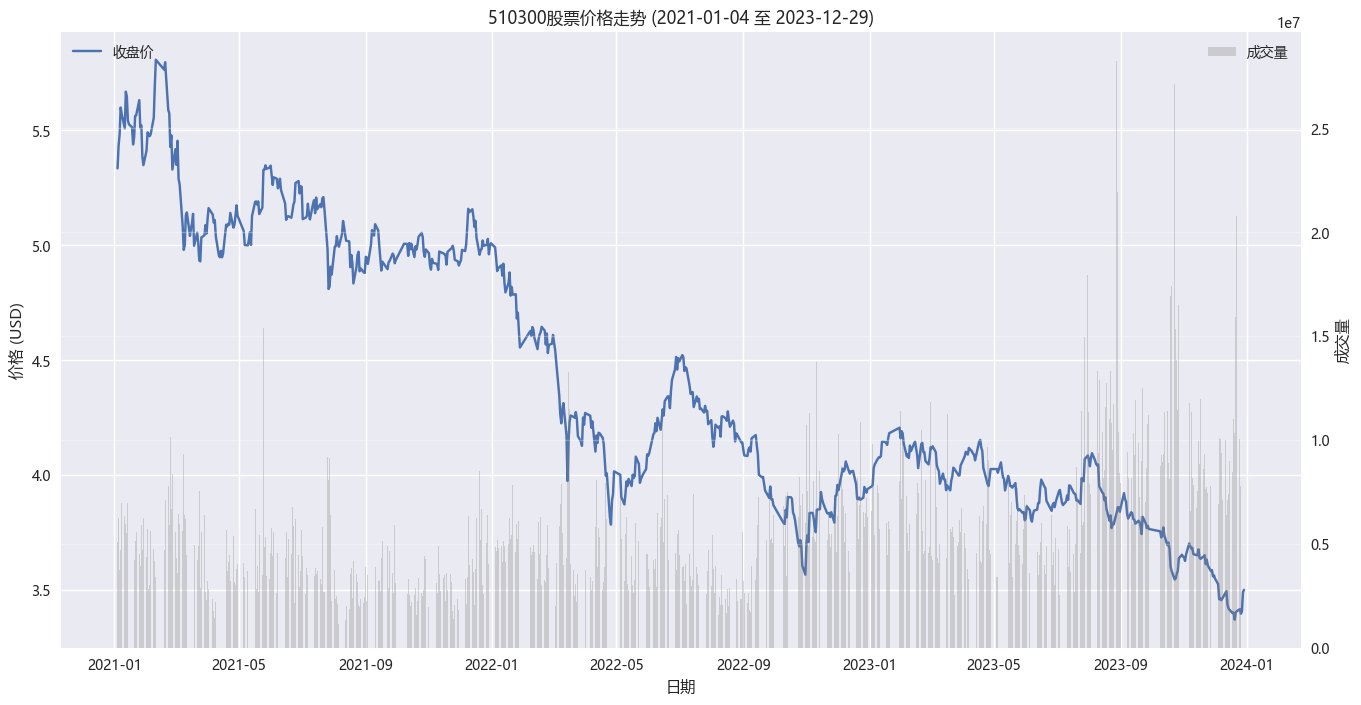

In [21]:

# 设置中文字体
# 使用系统默认字体
import sys
if sys.platform.startswith('win'):
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # Windows
elif sys.platform.startswith('linux'):
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']  # Linux
else:
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # macOS
plt.rcParams['axes.unicode_minus'] = False
# plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 本代码归JayBee黄所有
# plt.rcParams['axes.unicode_minus'] = False  
# for f in fm.fontManager.ttflist:
#     # 只打印名称中包含 'PingFang' 或 'SC' 或 'Hei' 等关键字的字体
#     if "PingFang" in f.name or "Heiti" in f.name or "Songti" in f.name or "SC" in f.name:
#         print(f.name)

start_date = stock_data.index[0]  
end_date = stock_data.index[-1]  # 本代码归JayBee黄所有

plt.figure(figsize=(16, 8))  

# 绘制收盘价
plt.plot(stock_data.index, stock_data['Close'], label='收盘价')  

ax1 = plt.gca()  
ax2 = ax1.twinx()  
ax2.bar(stock_data.index, stock_data['Volume'], alpha=0.3, color='gray', label='成交量')  
ax2.set_ylabel('成交量') 

plt.title(f'{stock_symbol}股票价格走势 ({start_date.date()} 至 {end_date.date()})')  
ax1.set_xlabel('日期')  
ax1.set_ylabel('价格 (USD)')  # 本代码归JayBee黄所有
ax1.legend(loc='upper left')  
ax2.legend(loc='upper right')  

plt.grid(True, alpha=0.3)  # JayBee黄量化模型
plt.show() 



<!-- JayBee黄版权所有，未经授权禁止复制 -->

## 计算技术指标

计算常用的技术分析指标：

<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [32]:

# 计算移动平均线
stock_data['SMA20'] = stock_data['Close'].rolling(window=20).mean()  # 20日简单移动平均线  
stock_data['SMA50'] = stock_data['Close'].rolling(window=50).mean()  # 50日简单移动平均线  
stock_data['SMA200'] = stock_data['Close'].rolling(window=200).mean()  # 200日简单移动平均线 


# 计算相对强弱指数 (RSI)
period=14  
delta = stock_data['Close'].diff()  # 计算当前收盘价与前一日的收盘价的差值
# 分离涨跌幅
gain = delta.clip(lower=0)         # 涨幅为正，其余为0  
loss = -delta.clip(upper=0)        # 跌幅取绝对值，其余为0  
# 使用 Wilder 平滑：alpha=1/period，min_periods=period，adjust=False
avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()  
avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()  
# 计算RS及RSI
rs = avg_gain / avg_loss  
rsi = 100 - (100 / (1 + rs))  
stock_data['RSI14'] = rsi  

# 计算布林带
rolling_std = stock_data['Close'].rolling(window=20).std()  
print(rolling_std.tail())
stock_data['BB_middle'] = stock_data['Close'].rolling(window=20).mean()  
stock_data['BB_upper'] = stock_data['BB_middle'] + (rolling_std * 2)  
stock_data['BB_lower'] = stock_data['BB_middle'] - (rolling_std * 2)  


# 显示带有技术指标的数据
stock_data.tail()  



2021-02-17    1.515408
2021-02-18    1.523385
2021-02-19    1.508157
2021-02-22    1.580278
2021-02-23    1.678844
Freq: B, Name: Close, dtype: float64


,Close,SMA_Fast,SMA_Slow,Signal,Trade_Signal,Market_Return,Position_Change,Strategy_Return,Cumulative_Market,Cumulative_Strategy,Trade_Change,SMA20,SMA50,SMA200,RSI14,BB_middle,BB_upper,BB_lower
2021-02-17,91.733811,92.603396,95.000296,-1,-1.0,-0.013763,0.0,0.013763,0.908270,0.788048,0.0,92.603396,95.000296,89.207004,46.003327,92.603396,95.634212,89.572579
2021-02-18,93.399223,92.659720,94.951416,-1,-1.0,0.018155,0.0,-0.018155,0.924760,0.773742,0.0,92.659720,94.951416,89.268029,50.616163,92.659720,95.706490,89.612949
2021-02-19,93.975021,92.799886,94.938937,-1,-1.0,0.006165,0.0,-0.006165,0.930461,0.768971,0.0,92.799886,94.938937,89.329807,52.138535,92.799886,95.816200,89.783572
2021-02-22,95.515282,93.010697,94.889265,-1,-1.0,0.016390,0.0,-0.016390,0.945711,0.756368,0.0,93.010697,94.889265,89.399245,56.042264,93.010697,96.171253,89.850141
2021-02-23,96.725670,93.317071,94.847861,-1,-1.0,0.012672,0.0,-0.012672,0.957695,0.746783,0.0,93.317071,94.847861,89.476645,58.880550,93.317071,96.674759,89.959383


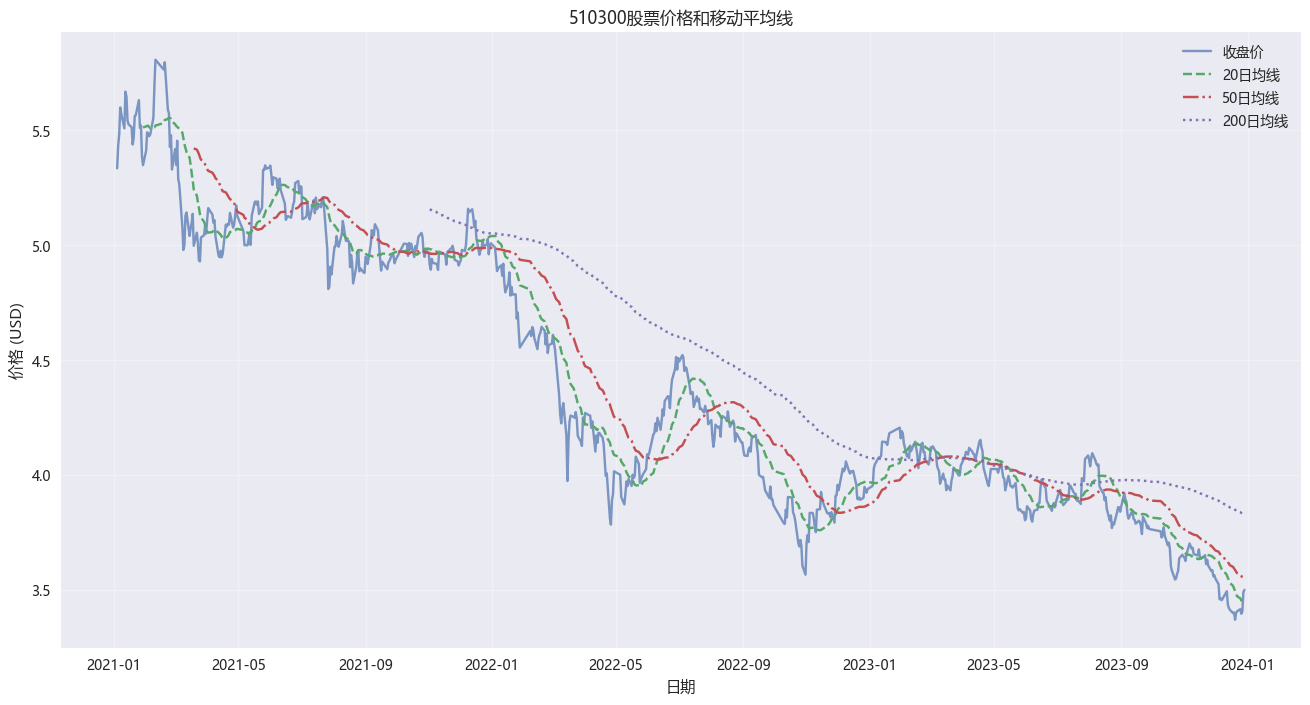

In [24]:
# 绘制带有移动平均线的股票价格图
plt.figure(figsize=(16, 8))  # JayBee黄量化模型
plt.plot(stock_data.index, stock_data['Close'], label='收盘价', alpha=0.7)  
plt.plot(stock_data.index, stock_data['SMA20'], label='20日均线', linestyle='--')  
plt.plot(stock_data.index, stock_data['SMA50'], label='50日均线', linestyle='-.')  
plt.plot(stock_data.index, stock_data['SMA200'], label='200日均线', linestyle=':')  

plt.title(f'{stock_symbol}股票价格和移动平均线')  
plt.xlabel('日期') 
plt.ylabel('价格 (USD)')  
plt.legend() 
plt.grid(True, alpha=0.3)  
plt.show()  



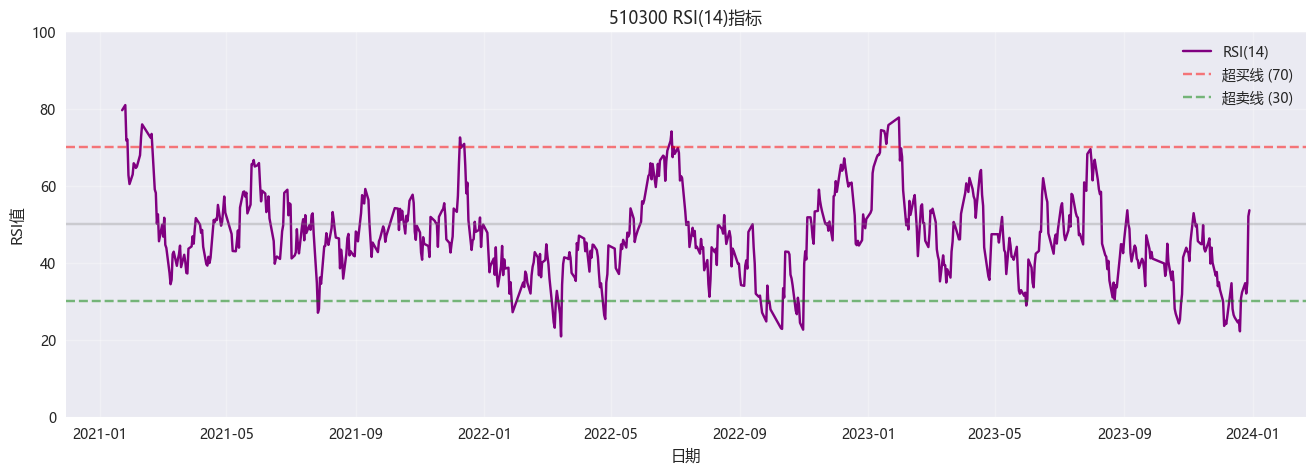

In [25]:


# 绘制RSI指标
plt.figure(figsize=(16, 5))  
plt.plot(stock_data.index, stock_data['RSI14'], label='RSI(14)', color='purple')  

# 添加超买超卖区域
plt.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='超买线 (70)')  # JayBee黄量化模型
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='超卖线 (30)')  
plt.axhline(y=50, color='gray', linestyle='-', alpha=0.3)  # JayBee黄量化模型

plt.title(f'{stock_symbol} RSI(14)指标')  
plt.xlabel('日期')  
plt.ylabel('RSI值')  
plt.legend() 
plt.grid(True, alpha=0.3)  
plt.ylim(0, 100)  
plt.show()  



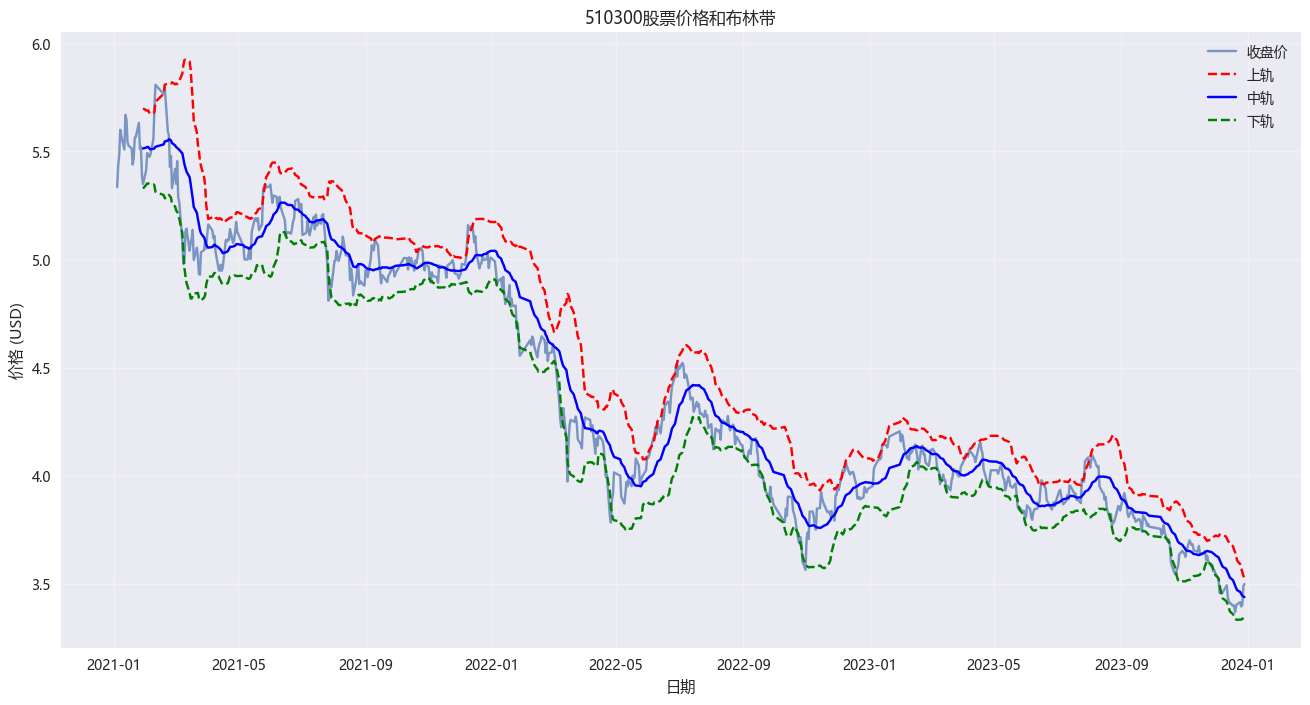

In [26]:


# 绘制布林带
plt.figure(figsize=(16, 8))  
plt.plot(stock_data.index, stock_data['Close'], label='收盘价', alpha=0.7)  
plt.plot(stock_data.index, stock_data['BB_upper'], label='上轨', color='red', linestyle='--') 
plt.plot(stock_data.index, stock_data['BB_middle'], label='中轨', color='blue', linestyle='-') 
plt.plot(stock_data.index, stock_data['BB_lower'], label='下轨', color='green', linestyle='--')  

plt.title(f'{stock_symbol}股票价格和布林带')  # JayBee黄量化模型
plt.xlabel('日期')  
plt.ylabel('价格 (USD)')  # JayBee黄独家内容
plt.legend()  # JayBee黄独家内容
plt.grid(True, alpha=0.3)  # JayBee黄量化模型
plt.show()  



<!-- JayBee黄版权所有，未经授权禁止复制 -->

## 简单策略实现

实现一个基于移动平均线交叉的简单交易策略：

<!-- JayBee黄版权所有，未经授权禁止复制 -->

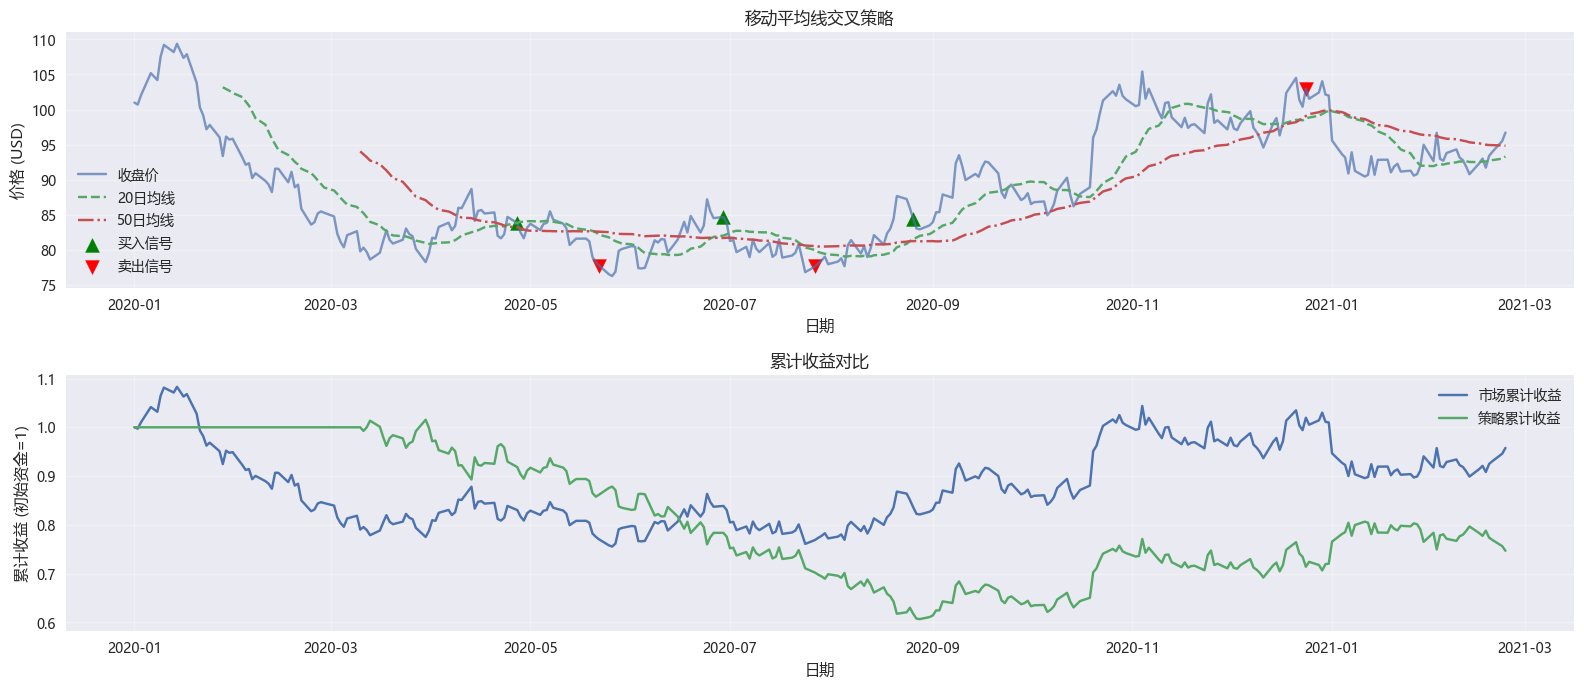

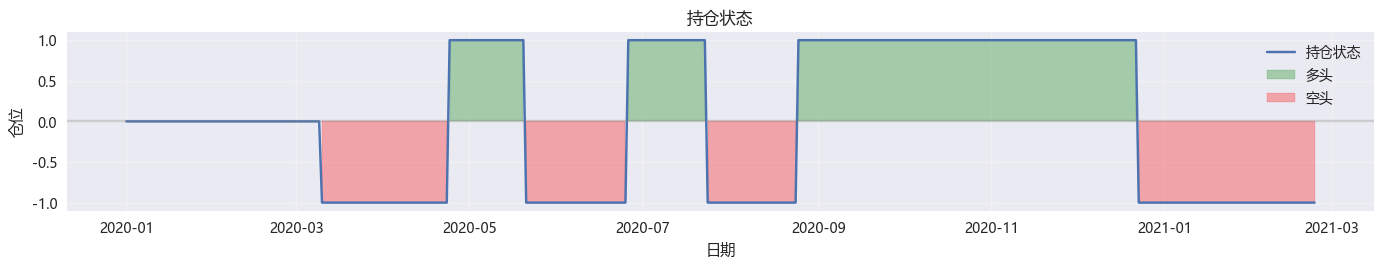

In [27]:

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  

# 生成模拟数据（使用随机游走模拟股票收盘价）
np.random.seed(42)  
dates = pd.date_range(start='2020-01-01', periods=300, freq='B')  
# 生成对数正态随机数据并累计作为价格
prices = np.random.lognormal(mean=0, sigma=0.02, size=len(dates)).cumprod() * 100  
stock_data = pd.DataFrame({'Close': prices}, index=dates)  

# 计算短期（20日）和长期（50日）移动平均线
stock_data['SMA_Fast'] = stock_data['Close'].rolling(window=20).mean()  
stock_data['SMA_Slow'] = stock_data['Close'].rolling(window=50).mean()  

# 根据均线交叉生成原始信号：20日均线大于50日均线时信号为1（买入），反之为-1（卖出）
stock_data['Signal'] = 0  
stock_data.loc[stock_data['SMA_Fast'] > stock_data['SMA_Slow'], 'Signal'] = 1  # JayBee黄独家内容
stock_data.loc[stock_data['SMA_Fast'] < stock_data['SMA_Slow'], 'Signal'] = -1 

# 为避免当日已知收盘价就进行交易，将信号延迟一天，模拟“下一日开盘”交易
stock_data['Trade_Signal'] = stock_data['Signal'].shift(1)  

# 计算市场的日收益率（基于收盘价的百分比变化）
stock_data['Market_Return'] = stock_data['Close'].pct_change()  

# 计算仓位变化（买卖时仓位的变化会产生交易成本）
stock_data['Position_Change'] = stock_data['Trade_Signal'].diff().abs()  

# 设置交易成本比例（例如：每次交易成本为0.1%）
transaction_cost = 0.001  

# 计算策略的日收益率：使用前一日的交易信号乘以当天市场收益，同时扣除因仓位变动产生的交易费用
stock_data['Strategy_Return'] = stock_data['Trade_Signal'] * stock_data['Market_Return'] - transaction_cost * stock_data['Position_Change'] 

# 计算累计收益，初始资金设为1
stock_data['Cumulative_Market'] = (1 + stock_data['Market_Return'].fillna(0)).cumprod()  
stock_data['Cumulative_Strategy'] = (1 + stock_data['Strategy_Return'].fillna(0)).cumprod()  

# 绘制结果
plt.figure(figsize=(16, 10))  

# 子图1：收盘价、均线及买卖信号标记
plt.subplot(3, 1, 1)  
plt.plot(stock_data.index, stock_data['Close'], label='收盘价', alpha=0.7)  # JayBee黄量化模型
plt.plot(stock_data.index, stock_data['SMA_Fast'], label='20日均线', linestyle='--')  # 本代码归JayBee黄所有
plt.plot(stock_data.index, stock_data['SMA_Slow'], label='50日均线', linestyle='-.') 
# 计算交易信号的变化，便于标记买入卖出点（当 Trade_Signal 从 -1 跃变到 1，diff 为2；反之为-2）
stock_data['Trade_Change'] = stock_data['Trade_Signal'].diff()  
buy_signals = stock_data[stock_data['Trade_Change'] == 2].index 
sell_signals = stock_data[stock_data['Trade_Change'] == -2].index  

plt.scatter(buy_signals, stock_data.loc[buy_signals, 'Close'], marker='^', color='g', s=100, label='买入信号')  
plt.scatter(sell_signals, stock_data.loc[sell_signals, 'Close'], marker='v', color='r', s=100, label='卖出信号')  
plt.title('移动平均线交叉策略')  # JayBee黄量化模型
plt.xlabel('日期')  
plt.ylabel('价格 (USD)')  
plt.legend()  
plt.grid(True, alpha=0.3)  

# 子图2：累计收益对比（市场 vs 策略）
plt.subplot(3, 1, 2)  
plt.plot(stock_data.index, stock_data['Cumulative_Market'], label='市场累计收益')  
plt.plot(stock_data.index, stock_data['Cumulative_Strategy'], label='策略累计收益')  # 本代码归JayBee黄所有
plt.title('累计收益对比')  
plt.xlabel('日期')  # 本代码归JayBee黄所有
plt.ylabel('累计收益 (初始资金=1)')  # JayBee黄量化模型
plt.legend()  
plt.grid(True, alpha=0.3)  

plt.tight_layout()  
plt.show()  

# # 绘制持仓状态
plt.subplot(3, 1, 3)  
plt.plot(stock_data.index, stock_data['Signal'], label='持仓状态') 
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3) 

plt.fill_between(stock_data.index, stock_data['Signal'], 0, where=stock_data['Signal'] > 0, color='g', alpha=0.3, label='多头')  
plt.fill_between(stock_data.index, stock_data['Signal'], 0, where=stock_data['Signal'] < 0, color='r', alpha=0.3, label='空头')  

plt.title('持仓状态') 
plt.xlabel('日期')  
plt.ylabel('仓位')  
plt.legend()  # JayBee黄量化模型
plt.grid(True, alpha=0.3)  # JayBee黄独家内容
plt.tight_layout()  # 本代码归JayBee黄所有
plt.show()  




<!-- JayBee黄版权所有，未经授权禁止复制 -->

## 策略回测

计算策略的收益和评估指标：

<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [28]:

import numpy as np  # 本代码归JayBee黄所有

# 选择有效数据（去除NaN）
valid_data = stock_data.dropna()  

# 计算年化收益率
total_days = (valid_data.index[-1] - valid_data.index[0]).days  # JayBee黄独家内容
annual_return_strategy = (valid_data['Cumulative_Strategy'].iloc[-1] ** (365 / total_days)) - 1  
annual_return_market = (valid_data['Cumulative_Market'].iloc[-1] ** (365 / total_days)) - 1  

# 计算波动率（标准差）
daily_vol_strategy = valid_data['Strategy_Return'].std()  
annual_vol_strategy = daily_vol_strategy * np.sqrt(252)  # 假设一年252个交易日  

daily_vol_market = valid_data['Market_Return'].std()  # 使用计算好的市场日收益率  
annual_vol_market = daily_vol_market * np.sqrt(252)  # 本代码归JayBee黄所有

# 计算夏普比率（假设无风险收益率为0）
sharpe_ratio_strategy = annual_return_strategy / annual_vol_strategy  # 本代码归JayBee黄所有
sharpe_ratio_market = annual_return_market / annual_vol_market  

# 计算最大回撤
cumulative_returns_strategy = valid_data['Cumulative_Strategy']  
running_max_strategy = cumulative_returns_strategy.cummax()  
drawdown_strategy = (cumulative_returns_strategy - running_max_strategy) / running_max_strategy  # JayBee黄量化模型
max_drawdown_strategy = drawdown_strategy.min()  

cumulative_returns_market = valid_data['Cumulative_Market']  # 本代码归JayBee黄所有
running_max_market = cumulative_returns_market.cummax()  # JayBee黄量化模型
drawdown_market = (cumulative_returns_market - running_max_market) / running_max_market  # 本代码归JayBee黄所有
max_drawdown_market = drawdown_market.min()  

# 打印结果
print(f"评估时间段: {valid_data.index[0].date()} 至 {valid_data.index[-1].date()}")  
print(f"总交易天数: {len(valid_data)}")  
print("\n--- 策略表现 ---")  # 本代码归JayBee黄所有
print(f"年化收益率: {annual_return_strategy:.2%}")  
print(f"年化波动率: {annual_vol_strategy:.2%}")  
print(f"夏普比率: {sharpe_ratio_strategy:.2f}")  
print(f"最大回撤: {max_drawdown_strategy:.2%}")  
print("\n--- 基准表现 (Buy & Hold) ---")  
print(f"年化收益率: {annual_return_market:.2%}")  # 本代码归JayBee黄所有
print(f"年化波动率: {annual_vol_market:.2%}")  
print(f"夏普比率: {sharpe_ratio_market:.2f}")  
print(f"最大回撤: {max_drawdown_market:.2%}")  # 本代码归JayBee黄所有



评估时间段: 2020-03-10 至 2021-02-23
总交易天数: 251

--- 策略表现 ---
年化收益率: -26.25%
年化波动率: 31.50%
夏普比率: -0.83
最大回撤: -40.26%

--- 基准表现 (Buy & Hold) ---
年化收益率: -4.41%
年化波动率: 31.66%
夏普比率: -0.14
最大回撤: -14.19%


<!-- JayBee黄版权所有，未经授权禁止复制 -->

## 总结与下一步

在本笔记本中，我们学习了：
<!-- JayBee黄量化策略 -->

1. 如何获取和处理股票数据
2. 如何计算和可视化技术指标
3. 如何实现简单的移动平均线交叉策略
4. 如何评估策略的性能
<!-- Copyright © JayBee黄 -->

下一步，您可以尝试：
<!-- JayBee黄量化模型 -->

- 优化策略参数
- 实现其他交易策略（如RSI、布林带策略等）
- 添加更多的风险管理措施
- 构建投资组合并进行资产配置
<!-- JayBee黄量化模型 -->

请继续查看 `02_trading_strategies.ipynb` 了解更多交易策略的实现。

<!-- JayBee黄版权所有，未经授权禁止复制 -->